# MIVA - Fase 3: Experimento Sintético
---

##### Geração e avaliação de datasets sintéticos com níveis controlados de concordância entre anotadores masculinos e femininos

#### Inputs necessários
* Nenhum arquivo externo — os datasets são gerados sinteticamente

#### Outputs gerados
* `data/sinteticos/SynSA-XX.csv` — 12 datasets sintéticos (XX = nível de concordância)
* `data/resultados_sinteticos/fase3_metricas_por_dataset.csv` — métricas agregadas por dataset
* `data/resultados_sinteticos/fase3_kappa_todos_classificadores.csv` — Cohen's κ por classificador e dataset
* Gráficos comparativos (curvas de κ, tabela NB detalhada)

### 1. Setup e Importações
---

In [34]:
# Importações de bibliotecas

import pandas as pd
import numpy as np
import os
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import cohen_kappa_score
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Seed global para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Bibliotecas carregadas com sucesso.")

Bibliotecas carregadas com sucesso.


In [35]:
# Criação dos diretórios de saída

Path('data/sinteticos').mkdir(parents=True, exist_ok=True)
Path('data/resultados_sinteticos').mkdir(parents=True, exist_ok=True)
Path('data/resultados_sinteticos/graficos_sinteticos').mkdir(parents=True, exist_ok=True)

print("Diretórios criados.")

Diretórios criados.


### 2. Geração dos Datasets Sintéticos
---

##### Cada dataset SynSA-XX contém 999 instâncias (3 classes × 333) com concordância controlada γ
##### Textos sintéticos com tokens placeholder (word1, word2, ...) de 20 a 100 palavras

In [36]:
def gerar_pares_rotulos_balanceados(classes, n_por_classe, gamma):
    """
    GenerateBalancedLabelPairs (Algorithm 1, Linha 3)
    
    Gera pares de rótulos (masculino, feminino) com:
    - Distribuição perfeitamente balanceada entre classes para AMBOS os gêneros
    - Taxa de concordância controlada por gamma
    
    Parâmetros:
    -----------
    classes : list
        Classes de sentimento (ex: ['negativa', 'neutra', 'positiva'])
    n_por_classe : int
        Número de instâncias por classe (N/3)
    gamma : float
        Taxa de concordância desejada entre 0 e 1
    
    Retorna:
    --------
    rotulos_masc, rotulos_fem : np.array, np.array
    """
    N = n_por_classe * len(classes)
    n_concordantes = int(round(gamma * N))
    n_discordantes = N - n_concordantes
    
    rotulos_masc = []
    rotulos_fem = []
    
    # --- Parte concordante: rótulos idênticos, balanceados ---
    # Distribui igualmente entre as 3 classes
    conc_por_classe = n_concordantes // len(classes)
    resto_conc = n_concordantes % len(classes)
    
    for i, cls in enumerate(classes):
        n = conc_por_classe + (1 if i < resto_conc else 0)
        rotulos_masc.extend([cls] * n)
        rotulos_fem.extend([cls] * n)
    
    # --- Parte discordante: rótulos diferentes, preservando balanço ---
    # Para cada instância discordante, o rótulo masculino e feminino
    # são de classes DIFERENTES, distribuídos para manter balanço global
    disc_por_classe = n_discordantes // len(classes)
    resto_disc = n_discordantes % len(classes)
    
    for i, cls in enumerate(classes):
        n = disc_por_classe + (1 if i < resto_disc else 0)
        outras_classes = [c for c in classes if c != cls]
        for j in range(n):
            rotulos_masc.append(cls)
            # Rótulo feminino: classe diferente, alternando entre as outras
            rotulos_fem.append(outras_classes[j % len(outras_classes)])
    
    return np.array(rotulos_masc), np.array(rotulos_fem)


def gerar_textos_sinteticos(N, L_min=20, L_max=100):
    """
    GenerateSyntheticTexts (Algorithm 1, Linha 4)
    
    Gera N textos sintéticos com tokens placeholder.
    Cada texto tem entre L_min e L_max tokens.
    
    Os textos são semanticamente neutros — o objetivo é isolar
    o efeito dos rótulos no comportamento dos classificadores.
    """
    textos = []
    for i in range(N):
        n_tokens = np.random.randint(L_min, L_max + 1)
        tokens = [f"word{np.random.randint(1, 501)}" for _ in range(n_tokens)]
        textos.append(' '.join(tokens))
    return textos


def gerar_dataset_sintetico(gamma, N=999, L_min=20, L_max=100, seed=SEED):
    """
    AssembleDataset + Shuffle (Algorithm 1, Linhas 5-7)
    
    Gera um dataset sintético completo SynSA-XX.
    
    Parâmetros:
    -----------
    gamma : float
        Taxa de concordância (0.50 a 0.99)
    N : int
        Número total de instâncias (múltiplo de 3)
    L_min, L_max : int
        Comprimento mínimo e máximo dos textos
    seed : int
        Seed para reprodutibilidade
    
    Retorna:
    --------
    pd.DataFrame com colunas: texto, rotulo_masculino, rotulo_feminino
    """
    np.random.seed(seed)
    
    classes = ['negativa', 'neutra', 'positiva']
    n_por_classe = N // len(classes)
    
    # Linha 3: pares de rótulos balanceados com concordância γ
    rotulos_masc, rotulos_fem = gerar_pares_rotulos_balanceados(
        classes, n_por_classe, gamma
    )
    
    # Linha 4: textos sintéticos
    textos = gerar_textos_sinteticos(N, L_min, L_max)
    
    # Linhas 5-6: montagem e shuffle
    df = pd.DataFrame({
        'texto': textos,
        'rotulo_masculino': rotulos_masc,
        'rotulo_feminino': rotulos_fem
    })
    
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    return df


print("Funções de geração definidas.")

Funções de geração definidas.


In [37]:
# =============================================================================
# GERAÇÃO DOS 12 DATASETS SINTÉTICOS
# =============================================================================

# Níveis de concordância conforme o artigo
NIVEIS_CONCORDANCIA = [99, 97, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]

datasets_sinteticos = {}

print("=" * 80)
print("GERAÇÃO DOS DATASETS SINTÉTICOS (SynSA-XX)")
print("=" * 80)

for nivel in NIVEIS_CONCORDANCIA:
    gamma = nivel / 100.0
    nome = f"SynSA-{nivel}"
    
    df = gerar_dataset_sintetico(gamma=gamma, N=999, seed=SEED)
    datasets_sinteticos[nome] = df
    
    # Salvar CSV
    output_path = f"data/sinteticos/{nome}.csv"
    df.to_csv(output_path, index=False, encoding='utf-8')
    
    # Concordância efetiva
    conc_efetiva = (df['rotulo_masculino'] == df['rotulo_feminino']).mean() * 100
    
    print(f"  {nome}: γ={gamma:.2f} | N={len(df)} | "
          f"Concordância efetiva={conc_efetiva:.2f}% | Salvo: {output_path}")

print(f"\n✔ {len(datasets_sinteticos)} datasets gerados com sucesso.")

GERAÇÃO DOS DATASETS SINTÉTICOS (SynSA-XX)
  SynSA-99: γ=0.99 | N=999 | Concordância efetiva=99.00% | Salvo: data/sinteticos/SynSA-99.csv
  SynSA-97: γ=0.97 | N=999 | Concordância efetiva=97.00% | Salvo: data/sinteticos/SynSA-97.csv
  SynSA-95: γ=0.95 | N=999 | Concordância efetiva=94.99% | Salvo: data/sinteticos/SynSA-95.csv
  SynSA-90: γ=0.90 | N=999 | Concordância efetiva=89.99% | Salvo: data/sinteticos/SynSA-90.csv
  SynSA-85: γ=0.85 | N=999 | Concordância efetiva=84.98% | Salvo: data/sinteticos/SynSA-85.csv
  SynSA-80: γ=0.80 | N=999 | Concordância efetiva=79.98% | Salvo: data/sinteticos/SynSA-80.csv
  SynSA-75: γ=0.75 | N=999 | Concordância efetiva=74.97% | Salvo: data/sinteticos/SynSA-75.csv
  SynSA-70: γ=0.70 | N=999 | Concordância efetiva=69.97% | Salvo: data/sinteticos/SynSA-70.csv
  SynSA-65: γ=0.65 | N=999 | Concordância efetiva=64.96% | Salvo: data/sinteticos/SynSA-65.csv
  SynSA-60: γ=0.60 | N=999 | Concordância efetiva=59.96% | Salvo: data/sinteticos/SynSA-60.csv
  SynSA

In [38]:
# =============================================================================
# VALIDAÇÃO: DISTRIBUIÇÃO DE CLASSES E CONCORDÂNCIA
# =============================================================================

print("=" * 80)
print("VALIDAÇÃO DOS DATASETS SINTÉTICOS")
print("=" * 80)
print(f"{'Dataset':<12} {'Conc.(%)':<10} {'Masc(neg/neu/pos)':<22} {'Fem(neg/neu/pos)':<22}")
print("-" * 70)

for nome in [f"SynSA-{n}" for n in NIVEIS_CONCORDANCIA]:
    df = datasets_sinteticos[nome]
    
    conc = (df['rotulo_masculino'] == df['rotulo_feminino']).mean() * 100
    
    dist_m = df['rotulo_masculino'].value_counts().reindex(
        ['negativa', 'neutra', 'positiva'], fill_value=0
    )
    dist_f = df['rotulo_feminino'].value_counts().reindex(
        ['negativa', 'neutra', 'positiva'], fill_value=0
    )
    
    print(f"  {nome:<10} {conc:>7.2f}%   "
          f"{dist_m['negativa']:>3}/{dist_m['neutra']:>3}/{dist_m['positiva']:>3}       "
          f"{dist_f['negativa']:>3}/{dist_f['neutra']:>3}/{dist_f['positiva']:>3}")

VALIDAÇÃO DOS DATASETS SINTÉTICOS
Dataset      Conc.(%)   Masc(neg/neu/pos)      Fem(neg/neu/pos)      
----------------------------------------------------------------------
  SynSA-99     99.00%   334/333/332       334/333/332
  SynSA-97     97.00%   333/333/333       333/333/333
  SynSA-95     94.99%   334/333/332       334/333/332
  SynSA-90     89.99%   334/333/332       334/333/332
  SynSA-85     84.98%   333/333/333       333/333/333
  SynSA-80     79.98%   334/333/332       334/333/332
  SynSA-75     74.97%   334/333/332       334/333/332
  SynSA-70     69.97%   333/333/333       333/333/333
  SynSA-65     64.96%   334/333/332       334/333/332
  SynSA-60     59.96%   334/333/332       334/333/332
  SynSA-55     54.95%   333/333/333       333/333/333
  SynSA-50     50.05%   334/333/332       333/334/332


### 3. Treinamento e Avaliação dos Classificadores
---

* Mesma pipeline da fase 2 (dados empíricos), adaptada para dados sintéticos
* Mesmo 4 classificadores da fase 2: SVM, NB, RF, LR
* 5-fold stratified cross-validation com splits idênticos entre modelos M e F
* Métricas: Cohen's κ, Weighted κ, χ², Cramér's V

In [39]:
# =============================================================================
# DEFINIÇÃO DOS CLASSIFICADORES E FUNÇÕES DE AVALIAÇÃO
# =============================================================================

def get_classificadores():
    """
    Retorna dicionário com os 4 classificadores (mesmos da Fase 2).
    Configuração padrão Scikit-Learn.
    """
    return {
        'SVM': SVC(kernel='linear', random_state=SEED),
        'NB':  MultinomialNB(),
        'RF':  RandomForestClassifier(random_state=SEED),
        'LR':  LogisticRegression(max_iter=1000, random_state=SEED)
    }


def calcular_cramers_v(y1, y2):
    """
    Calcula Cramér's V a partir de duas séries categóricas.
    
    Interpretação (Alan & Duncan, 1997):
    - < 0.20: muito baixa
    - 0.20–0.39: baixa
    - 0.40–0.69: moderada
    - 0.70–0.89: alta
    - 0.90–1.00: muito alta
    """
    tabela = pd.crosstab(y1, y2)
    chi2, p_value, dof, expected = chi2_contingency(tabela)
    n = len(y1)
    min_dim = min(tabela.shape) - 1
    if min_dim == 0 or n == 0:
        return 0.0, chi2, p_value
    v = np.sqrt(chi2 / (n * min_dim))
    return v, chi2, p_value


def avaliar_concordancia_anotadores(df):
    """
    Calcula métricas de concordância entre anotadores sintéticos (M vs F).
    Equivalente à análise humano-humano da Fase 2.
    """
    y_masc = df['rotulo_masculino']
    y_fem = df['rotulo_feminino']
    
    consenso = (y_masc == y_fem).mean() * 100
    kappa = cohen_kappa_score(y_masc, y_fem)
    kappa_w = cohen_kappa_score(y_masc, y_fem, weights='linear')
    cramers_v, chi2_stat, p_value = calcular_cramers_v(y_masc, y_fem)
    
    return {
        'Consenso (%)': consenso,
        'Cohen κ': kappa,
        'Weighted κ': kappa_w,
        'χ² (stat)': chi2_stat,
        'p-value': p_value,
        'Cramér V': cramers_v
    }


def treinar_e_comparar(df, nome_dataset):
    """
    Pipeline de treinamento e comparação de modelos por gênero.
    
    Para cada classificador:
    1. Vetoriza textos com TF-IDF (unigrams + bigrams)
    2. Treina modelo M (rótulos masculinos) via 5-fold CV
    3. Treina modelo F (rótulos femininos) via 5-fold CV (mesmos splits)
    4. Compara predições M vs F com Cohen's κ, χ², Cramér's V
    
    Retorna dict com métricas por classificador.
    """
    # TF-IDF: mesma configuração da Fase 2
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=5000
    )
    X = tfidf.fit_transform(df['texto'])
    
    y_masc = df['rotulo_masculino'].values
    y_fem = df['rotulo_feminino'].values
    
    # Cross-validation: splits idênticos para ambos os modelos
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    resultados = {}
    classificadores = get_classificadores()
    
    for nome_clf, clf_base in classificadores.items():
        # Predições via cross-validation
        # Stratificação pelo rótulo masculino (garantir splits comparáveis)
        try:
            pred_masc = cross_val_predict(clf_base, X, y_masc, cv=cv)
        except Exception:
            # Fallback: se stratificação falhar por classe rara
            pred_masc = cross_val_predict(clf_base, X, y_masc, cv=5)
        
        try:
            pred_fem = cross_val_predict(clf_base, X, y_fem, cv=cv)
        except Exception:
            pred_fem = cross_val_predict(clf_base, X, y_fem, cv=5)
        
        # Métricas: comparação predição_M vs predição_F
        kappa = cohen_kappa_score(pred_masc, pred_fem)
        kappa_w = cohen_kappa_score(pred_masc, pred_fem, weights='linear')
        cramers_v, chi2_stat, p_value = calcular_cramers_v(
            pd.Series(pred_masc), pd.Series(pred_fem)
        )
        
        resultados[nome_clf] = {
            'Cohen κ': kappa,
            'Weighted κ': kappa_w,
            'χ² (stat)': chi2_stat,
            'p-value': p_value,
            'Cramér V': cramers_v
        }
    
    return resultados


print("Funções de avaliação definidas.")

Funções de avaliação definidas.


In [40]:
# =============================================================================
# EXECUÇÃO: TREINAMENTO E AVALIAÇÃO PARA TODOS OS 12 DATASETS
# =============================================================================

resultados_todos = {}       # {nome_dataset: {nome_clf: {métricas}}}
metricas_anotadores = {}    # {nome_dataset: {métricas anotadores}}

print("=" * 80)
print("TREINAMENTO E COMPARAÇÃO DE MODELOS POR GÊNERO")
print("=" * 80)

for nivel in NIVEIS_CONCORDANCIA:
    nome = f"SynSA-{nivel}"
    df = datasets_sinteticos[nome]
    
    print(f"\n{'─' * 60}")
    print(f"  Processando {nome} (γ = {nivel/100:.2f})")
    print(f"{'─' * 60}")
    
    # 1. Métricas anotadores (M vs F sintéticos)
    met_anot = avaliar_concordancia_anotadores(df)
    metricas_anotadores[nome] = met_anot
    print(f"  Anotadores — κ: {met_anot['Cohen κ']:.4f} | "
          f"Cramér V: {met_anot['Cramér V']:.4f} | "
          f"χ²: {met_anot['χ² (stat)']:.2f}")
    
    # 2. Treinamento e comparação dos classificadores
    res_clf = treinar_e_comparar(df, nome)
    resultados_todos[nome] = res_clf
    
    for clf_nome, met in res_clf.items():
        print(f"  {clf_nome:<4} — κ: {met['Cohen κ']:.4f} | "
              f"Cramér V: {met['Cramér V']:.4f} | "
              f"χ²: {met['χ² (stat)']:.2f}")

print(f"\n{'=' * 80}")
print("✔ Processamento concluído para todos os 12 datasets.")
print(f"{'=' * 80}")

TREINAMENTO E COMPARAÇÃO DE MODELOS POR GÊNERO

────────────────────────────────────────────────────────────
  Processando SynSA-99 (γ = 0.99)
────────────────────────────────────────────────────────────
  Anotadores — κ: 0.9850 | Cramér V: 0.9850 | χ²: 1938.49
  SVM  — κ: 0.6354 | Cramér V: 0.6372 | χ²: 811.34
  NB   — κ: 0.6475 | Cramér V: 0.6504 | χ²: 845.13
  RF   — κ: 0.2503 | Cramér V: 0.2527 | χ²: 127.62
  LR   — κ: 0.6740 | Cramér V: 0.6750 | χ²: 910.45

────────────────────────────────────────────────────────────
  Processando SynSA-97 (γ = 0.97)
────────────────────────────────────────────────────────────
  Anotadores — κ: 0.9550 | Cramér V: 0.9550 | χ²: 1822.05
  SVM  — κ: 0.5576 | Cramér V: 0.5582 | χ²: 622.52
  NB   — κ: 0.5271 | Cramér V: 0.5286 | χ²: 558.36
  RF   — κ: 0.2022 | Cramér V: 0.2037 | χ²: 82.93
  LR   — κ: 0.5524 | Cramér V: 0.5526 | χ²: 610.08

────────────────────────────────────────────────────────────
  Processando SynSA-95 (γ = 0.95)
────────────────────

### 4. Tabela Consolidada — Todos os Classificadores
---

##### Cohen's κ entre modelos M e F para cada classificador, por dataset
##### Inclui também o κ dos anotadores sintéticos como referência

In [41]:
# =============================================================================
# TABELA CONSOLIDADA — κ POR CLASSIFICADOR E DATASET
# =============================================================================

tabela_kappa = []

for nivel in NIVEIS_CONCORDANCIA:
    nome = f"SynSA-{nivel}"
    met_anot = metricas_anotadores[nome]
    
    linha = {
        'Dataset': nome,
        'Anotadores κ': met_anot['Cohen κ']
    }
    
    for clf_nome in ['SVM', 'NB', 'RF', 'LR']:
        linha[f'{clf_nome} κ'] = resultados_todos[nome][clf_nome]['Cohen κ']
    
    tabela_kappa.append(linha)

df_kappa = pd.DataFrame(tabela_kappa)

print("=" * 80)
print("COHEN'S κ — ANOTADORES E MODELOS POR DATASET")
print("=" * 80)
print(df_kappa.to_string(index=False, float_format='{:.4f}'.format))

# Salvar
df_kappa.to_csv('data/resultados_sinteticos/kappa_todos_classificadores.csv', index=False)
print("\n✔ Tabela salva: data/resultados_sinteticos/kappa_todos_classificadores.csv")

COHEN'S κ — ANOTADORES E MODELOS POR DATASET
 Dataset  Anotadores κ  SVM κ   NB κ   RF κ   LR κ
SynSA-99        0.9850 0.6354 0.6475 0.2503 0.6740
SynSA-97        0.9550 0.5576 0.5271 0.2022 0.5524
SynSA-95        0.9249 0.4704 0.4822 0.1621 0.5120
SynSA-90        0.8498 0.3941 0.3896 0.1571 0.4188
SynSA-85        0.7748 0.4051 0.4129 0.1787 0.4056
SynSA-80        0.6997 0.3583 0.3472 0.1523 0.3735
SynSA-75        0.6246 0.2957 0.2928 0.1415 0.2888
SynSA-70        0.5495 0.2718 0.2769 0.1049 0.2583
SynSA-65        0.4745 0.2473 0.2188 0.0738 0.2498
SynSA-60        0.3994 0.1562 0.1459 0.0946 0.1848
SynSA-55        0.3243 0.1228 0.1049 0.0471 0.1323
SynSA-50        0.2507 0.0975 0.1043 0.0614 0.1256

✔ Tabela salva: data/resultados_sinteticos/kappa_todos_classificadores.csv


In [42]:
# =============================================================================
# TABELA CONSOLIDADA — CRAMÉR'S V POR CLASSIFICADOR E DATASET
# =============================================================================

tabela_cramers = []

for nivel in NIVEIS_CONCORDANCIA:
    nome = f"SynSA-{nivel}"
    met_anot = metricas_anotadores[nome]
    
    linha = {
        'Dataset': nome,
        'Anotadores V': met_anot['Cramér V']
    }
    
    for clf_nome in ['SVM', 'NB', 'RF', 'LR']:
        linha[f'{clf_nome} V'] = resultados_todos[nome][clf_nome]['Cramér V']
    
    tabela_cramers.append(linha)

df_cramers = pd.DataFrame(tabela_cramers)

print("=" * 80)
print("CRAMÉR'S V — ANOTADORES E MODELOS POR DATASET")
print("=" * 80)
print(df_cramers.to_string(index=False, float_format='{:.4f}'.format))

# Salvar
df_cramers.to_csv('data/resultados_sinteticos/cramers_todos_classificadores.csv', index=False)
print("\n✔ Tabela salva: data/resultados_sinteticos/cramers_todos_classificadores.csv")

CRAMÉR'S V — ANOTADORES E MODELOS POR DATASET
 Dataset  Anotadores V  SVM V   NB V   RF V   LR V
SynSA-99        0.9850 0.6372 0.6504 0.2527 0.6750
SynSA-97        0.9550 0.5582 0.5286 0.2037 0.5526
SynSA-95        0.9249 0.4710 0.4942 0.1717 0.5128
SynSA-90        0.8499 0.3948 0.3942 0.1592 0.4200
SynSA-85        0.7748 0.4083 0.4175 0.1823 0.4077
SynSA-80        0.6997 0.3605 0.3602 0.1568 0.3746
SynSA-75        0.6246 0.2963 0.3009 0.1455 0.2892
SynSA-70        0.5495 0.2817 0.2848 0.1119 0.2668
SynSA-65        0.4745 0.2541 0.2358 0.0929 0.2549
SynSA-60        0.3994 0.1579 0.1478 0.1127 0.1881
SynSA-55        0.3243 0.1289 0.1103 0.0579 0.1368
SynSA-50        0.2508 0.1052 0.1110 0.0865 0.1299

✔ Tabela salva: data/resultados_sinteticos/cramers_todos_classificadores.csv


### 5. Visualizações
---
##### Gráficos comparativos adicionais para Cramér's V e métricas NB

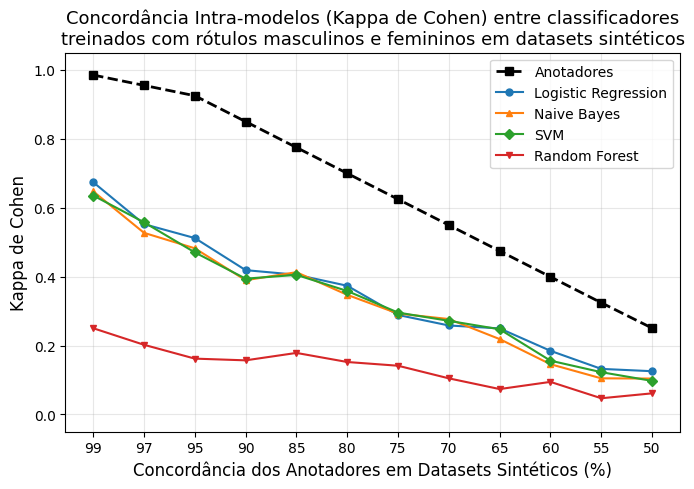

✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/kappa_por_classificador.png


In [43]:
# =============================================================================
# GRÁFICO 1 — COHEN'S KAPPA POR CLASSIFICADOR (Figura 2 do artigo)
# =============================================================================

fig, ax = plt.subplots(figsize=(7, 5))

niveis = NIVEIS_CONCORDANCIA  # [99, 97, 95, ..., 50]
x_labels = [str(n) for n in niveis]

# Curva dos anotadores
kappas_anot = [metricas_anotadores[f'SynSA-{n}']['Cohen κ'] for n in niveis]
ax.plot(x_labels, kappas_anot, 'k--', marker='s', linewidth=2,
        markersize=6, label='Anotadores', zorder=5)

# Curvas dos classificadores
cores = {'LR': '#1f77b4', 'NB': '#ff7f0e', 'SVM': '#2ca02c', 'RF': '#d62728'}
marcadores = {'LR': 'o', 'NB': '^', 'SVM': 'D', 'RF': 'v'}

for clf_nome in ['LR', 'NB', 'SVM', 'RF']:
    kappas = [resultados_todos[f'SynSA-{n}'][clf_nome]['Cohen κ'] for n in niveis]
    ax.plot(x_labels, kappas, marker=marcadores[clf_nome], linewidth=1.5,
            markersize=5, label={
                'LR': 'Logistic Regression',
                'NB': 'Naive Bayes',
                'SVM': 'SVM',
                'RF': 'Random Forest'
            }[clf_nome], color=cores[clf_nome])

ax.set_xlabel('Concordância dos Anotadores em Datasets Sintéticos (%)', fontsize=12)
ax.set_ylabel("Kappa de Cohen", fontsize=12)
ax.set_title("Concordância Intra-modelos (Kappa de Cohen) entre classificadores\n"
             "treinados com rótulos masculinos e femininos em datasets sintéticos",
             fontsize=13)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/resultados_sinteticos/graficos_sinteticos/kappa_por_classificador.png', dpi=300, bbox_inches='tight')
plt.show()

print("✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/kappa_por_classificador.png")


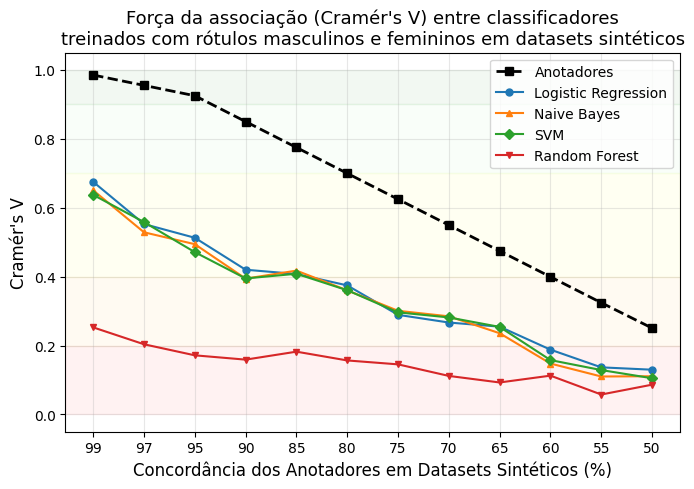

✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/cramers_v_por_classificador.png


In [44]:
# =============================================================================
# GRÁFICO 2 — CRAMÉR'S V POR CLASSIFICADOR
# =============================================================================

fig, ax = plt.subplots(figsize=(7, 5))

# Curva dos anotadores
vs_anot = [metricas_anotadores[f'SynSA-{n}']['Cramér V'] for n in niveis]
ax.plot(x_labels, vs_anot, 'k--', marker='s', linewidth=2,
        markersize=6, label='Anotadores', zorder=5)

# Curvas dos classificadores
for clf_nome in ['LR', 'NB', 'SVM', 'RF']:
    vs = [resultados_todos[f'SynSA-{n}'][clf_nome]['Cramér V'] for n in niveis]
    ax.plot(x_labels, vs, marker=marcadores[clf_nome], linewidth=1.5,
            markersize=5, label={
                'LR': 'Logistic Regression',
                'NB': 'Naive Bayes',
                'SVM': 'SVM',
                'RF': 'Random Forest'
            }[clf_nome], color=cores[clf_nome])

ax.set_xlabel('Concordância dos Anotadores em Datasets Sintéticos (%)', fontsize=12)
ax.set_ylabel("Cramér's V", fontsize=12)
ax.set_title("Força da associação (Cramér's V) entre classificadores\n"
             "treinados com rótulos masculinos e femininos em datasets sintéticos",
             fontsize=13)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)

# Faixas de interpretação (Alan & Duncan, 1997)
ax.axhspan(0.0, 0.20, alpha=0.05, color='red', label='_nolegend_')
ax.axhspan(0.20, 0.40, alpha=0.05, color='orange', label='_nolegend_')
ax.axhspan(0.40, 0.70, alpha=0.05, color='yellow', label='_nolegend_')
ax.axhspan(0.70, 0.90, alpha=0.05, color='lightgreen', label='_nolegend_')
ax.axhspan(0.90, 1.00, alpha=0.05, color='green', label='_nolegend_')

plt.tight_layout()
plt.savefig('data/resultados_sinteticos/graficos_sinteticos/cramers_v_por_classificador.png', dpi=300, bbox_inches='tight')
plt.show()

print("✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/cramers_v_por_classificador.png")


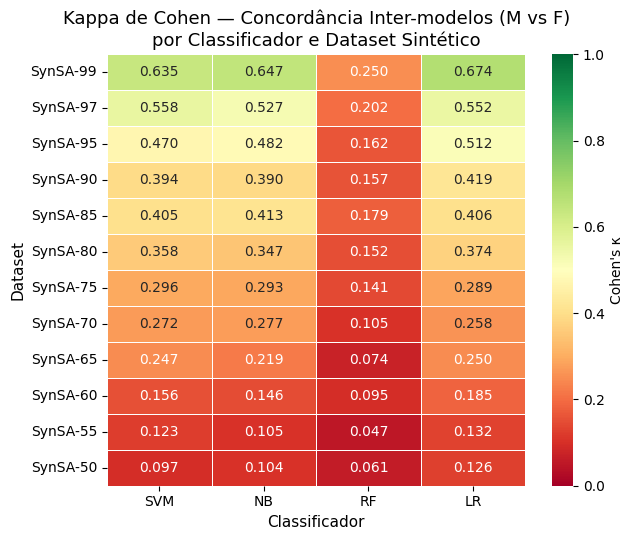

✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/fase3_heatmap_kappa.png


In [45]:
# =============================================================================
# GRÁFICO 3 — HEATMAP: COHEN'S KAPPA (CLASSIFICADOR × DATASET)
# =============================================================================

# Preparar dados para heatmap
heatmap_data = df_kappa.set_index('Dataset')[['SVM κ', 'NB κ', 'RF κ', 'LR κ']]
heatmap_data.columns = ['SVM', 'NB', 'RF', 'LR']

fig, ax = plt.subplots(figsize=(6.5, 5.5))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': "Cohen's κ"}
)

ax.set_title("Kappa de Cohen — Concordância Inter-modelos (M vs F)\npor Classificador e Dataset Sintético",
             fontsize=13)
ax.set_ylabel('Dataset', fontsize=11)
ax.set_xlabel('Classificador', fontsize=11)

plt.tight_layout()
plt.savefig('data/resultados_sinteticos/graficos_sinteticos/heatmap_kappa.png', dpi=300, bbox_inches='tight')
plt.show()

print("✔ Gráfico salvo: data/resultados_sinteticos/graficos_sinteticos/fase3_heatmap_kappa.png")


### 6. Exportação Consolidada para Fase 4
---

Salva todos os resultados em formato padronizado para integração<br>
com os resultados empíricos da Fase 2 na análise unificada (Fase 4)

In [46]:
# =============================================================================
# EXPORTAÇÃO — MÉTRICAS CONSOLIDADAS PARA FASE 4
# =============================================================================

# Formato longo (long format) para facilitar merge com Fase 2
registros = []

for nivel in NIVEIS_CONCORDANCIA:
    nome = f"SynSA-{nivel}"
    met_anot = metricas_anotadores[nome]
    
    # Linha dos anotadores
    registros.append({
        'fase': 'fase3_sintetico',
        'dataset': nome,
        'concordancia_alvo': nivel,
        'fonte': 'Anotadores',
        'cohen_kappa': met_anot['Cohen κ'],
        'weighted_kappa': met_anot['Weighted κ'],
        'chi2_stat': met_anot['χ² (stat)'],
        'p_value': met_anot['p-value'],
        'cramers_v': met_anot['Cramér V']
    })
    
    # Linhas dos classificadores
    for clf_nome in ['SVM', 'NB', 'RF', 'LR']:
        met = resultados_todos[nome][clf_nome]
        registros.append({
            'fase': 'fase3_sintetico',
            'dataset': nome,
            'concordancia_alvo': nivel,
            'fonte': clf_nome,
            'cohen_kappa': met['Cohen κ'],
            'weighted_kappa': met['Weighted κ'],
            'chi2_stat': met['χ² (stat)'],
            'p_value': met['p-value'],
            'cramers_v': met['Cramér V']
        })

df_consolidado = pd.DataFrame(registros)

output_path = 'data/resultados_sinteticos/metricas_sinteticas_consolidadas.csv'
df_consolidado.to_csv(output_path, index=False)

print("=" * 80)
print("EXPORTAÇÃO CONSOLIDADA PARA FASE 4")
print("=" * 80)
print(f"Total de registros: {len(df_consolidado)}")
print(f"  ({len(NIVEIS_CONCORDANCIA)} datasets × (1 anotadores + 4 classificadores) = "
      f"{len(NIVEIS_CONCORDANCIA) * 5} linhas)")
print(f"\nColunas: {list(df_consolidado.columns)}")
print(f"\n✔ Arquivo salvo: {output_path}")
print(f"\nAmostra:")
print(df_consolidado.head(10).to_string(index=False))

EXPORTAÇÃO CONSOLIDADA PARA FASE 4
Total de registros: 60
  (12 datasets × (1 anotadores + 4 classificadores) = 60 linhas)

Colunas: ['fase', 'dataset', 'concordancia_alvo', 'fonte', 'cohen_kappa', 'weighted_kappa', 'chi2_stat', 'p_value', 'cramers_v']

✔ Arquivo salvo: data/resultados_sinteticos/metricas_sinteticas_consolidadas.csv

Amostra:
           fase  dataset  concordancia_alvo      fonte  cohen_kappa  weighted_kappa   chi2_stat       p_value  cramers_v
fase3_sintetico SynSA-99                 99 Anotadores     0.984985        0.984234 1938.485574  0.000000e+00   0.984994
fase3_sintetico SynSA-99                 99        SVM     0.635395        0.626629  811.340702 2.684403e-174   0.637241
fase3_sintetico SynSA-99                 99         NB     0.647467        0.642753  845.132664 1.284385e-181   0.650376
fase3_sintetico SynSA-99                 99         RF     0.250307        0.240838  127.618482  1.257870e-26   0.252731
fase3_sintetico SynSA-99                 99       

In [47]:
# =============================================================================
# RESUMO FINAL
# =============================================================================

print("=" * 80)
print("FASE 3 — RESUMO DE ARQUIVOS GERADOS")
print("=" * 80)

arquivos_gerados = [
    ('Datasets Sintéticos', 'data/sinteticos/SynSA-XX.csv', '12 arquivos'),
    ('κ Todos Classificadores', 'data/resultados_sinteticos/kappa_todos_classificadores.csv', '1 arquivo'),
    ('V Todos Classificadores', 'data/resultados_sinteticos/cramers_todos_classificadores.csv', '1 arquivo'),
    ('Métricas Consolidadas (F4)', 'data/resultados_sinteticos/metricas_sinteticas_consolidadas.csv', '1 arquivo'),
    ('Gráfico κ por Classificador', 'data/resultados_sinteticos/graficos_sinteticos/kappa_por_classificador.png', '1 arquivo'),
    ('Gráfico V por Classificador', 'data/resultados_sinteticos/graficos_sinteticos/cramers_v_por_classificador.png', '1 arquivo'),
    ('Heatmap κ', 'data/resultados_sinteticos/graficos_sinteticos/heatmap_kappa.png', '1 arquivo'),
]

for desc, path, qtd in arquivos_gerados:
    print(f"  ✔ {desc:<30} → {path:<55} ({qtd})")

print(f"\n{'=' * 80}")
print("✔ FASE 3 CONCLUÍDA COM SUCESSO")
print("  Próximo passo: Fase 4 — Análise Unificada (empírico + sintético)")
print(f"{'=' * 80}")

FASE 3 — RESUMO DE ARQUIVOS GERADOS
  ✔ Datasets Sintéticos            → data/sinteticos/SynSA-XX.csv                            (12 arquivos)
  ✔ κ Todos Classificadores        → data/resultados_sinteticos/kappa_todos_classificadores.csv (1 arquivo)
  ✔ V Todos Classificadores        → data/resultados_sinteticos/cramers_todos_classificadores.csv (1 arquivo)
  ✔ Métricas Consolidadas (F4)     → data/resultados_sinteticos/metricas_sinteticas_consolidadas.csv (1 arquivo)
  ✔ Gráfico κ por Classificador    → data/resultados_sinteticos/graficos_sinteticos/kappa_por_classificador.png (1 arquivo)
  ✔ Gráfico V por Classificador    → data/resultados_sinteticos/graficos_sinteticos/cramers_v_por_classificador.png (1 arquivo)
  ✔ Heatmap κ                      → data/resultados_sinteticos/graficos_sinteticos/heatmap_kappa.png (1 arquivo)

✔ FASE 3 CONCLUÍDA COM SUCESSO
  Próximo passo: Fase 4 — Análise Unificada (empírico + sintético)


## Resumo Interpretativo (Fase 3 - Experimento Sint?tico)

Nesta fase, a **concord?ncia-alvo de cada dataset sint?tico** foi tratada como uma emula??o controlada das diverg?ncias naturais entre anotadores dos dois sexos, permitindo reproduzir a l?gica anal?tica da Fase 2 em m?ltiplos cen?rios.

1. **M?dulo I (baseline entre anota??es sint?ticas A/B)**
- Os baselines (`kappa_inicial`) variam de forma ordenada com a concord?ncia-alvo:
  - de `0.2507` (SynSA-50) at? `0.9850` (SynSA-99).
- Esse comportamento confirma que os cen?rios sint?ticos cobrem um gradiente amplo de diverg?ncia inicial entre anotadores.

2. **M?dulos II e III (treinamento pareado e diverg?ncia entre modelos)**
- A concord?ncia m?dia entre modelos A/B (`kappa_modelos`) permanece abaixo do baseline dos anotadores em todos os cen?rios, produzindo `delta_kappa > 0` em 100% dos casos.
- M?dias de `delta_kappa` por modelo (12 cen?rios):
  - `LR = 0.3030`
  - `NB = 0.3219`
  - `SVM = 0.3167`
  - `RF = 0.5155` (maior amplifica??o m?dia)

3. **M?dulo IV (amplifica??o e severidade)**
- Distribui??o de severidade por modelo:
  - **LR:** 1 Leve, 4 Moderada, 7 Severa
  - **NB:** 1 Leve, 4 Moderada, 7 Severa
  - **SVM:** 0 Leve, 5 Moderada, 7 Severa
  - **RF:** 0 Leve, 2 Moderada, 10 Severa
- A taxa global de amplifica??o no estudo sint?tico ? de `100%` (`delta_kappa > 0` em 48/48 combina??es dataset-modelo).

4. **Testes estat?sticos (paralelos ? Fase 2)**
- No consolidado sint?tico, as associa??es (qui-quadrado/Cram?r's V) para os modelos s?o majoritariamente significativas (`p < 0.05` em 47/48 casos).
- Exce??o observada: `RF` em `SynSA-55` (`kappa ? 0.0471`, `p ? 0.1522`).

5. **Tend?ncia com a diverg?ncia inicial (concord?ncia-alvo)**
- A m?dia de `delta_kappa` cresce de `0.1536` (50%) at? `0.5183` (95%), com leve recuo nos n?veis extremos de 97% e 99%.
- Correla??o de Spearman entre concord?ncia-alvo e `delta_kappa` por modelo:
  - `LR = 0.8182`
  - `NB = 0.8671`
  - `SVM = 0.8951`
  - `RF = 0.9720`
- Em s?ntese, h? tend?ncia monot?nica positiva: cen?rios com maior alinhamento inicial entre anotadores tendem a exibir maior gap ap?s modelagem.

**Conclus?o sint?tica da Fase 3:** replicando a estrutura anal?tica da Fase 2 em cen?rios controlados, observa-se evid?ncia robusta de amplifica??o de vi?s pelo pipeline de modelagem, com predomin?ncia de severidade moderada/severa e efeito particularmente intenso no RF.
